In [64]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchinfo import summary
import torchvision.models as models

In [65]:
preprocessing = transforms.Compose([
    transforms.Resize((30,30)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [66]:
file_dir = './traffic_sign/myData'
imgDS = ImageFolder(root = file_dir, transform = preprocessing)

In [67]:
# imgDS.class_to_idx

In [68]:
# dataset에서 train, valid, test를 나누어보자
seed_gen = torch.Generator().manual_seed(42)
tr, val, ts = 0.7,0.1,0.2
trainDS, validDS, testDS = random_split(imgDS, [tr, val, ts], generator=seed_gen)
print(len(trainDS), len(validDS), len(testDS))

51198 7314 14627


In [69]:
# 각 분류별로 dataloader를 생성해보자
batch_size = 300
train_dl = DataLoader(trainDS, batch_size=batch_size, shuffle=True, drop_last = True)
valid_dl = DataLoader(validDS, batch_size=batch_size, shuffle=True, drop_last = True)
test_dl = DataLoader(testDS, batch_size = batch_size, shuffle=True, drop_last = True)
print(len(train_dl), len(valid_dl), len(test_dl))

170 24 48


In [70]:
# 모델 인스턴스 생성 : 사전 학습된 모델 로딩 => 가중치를 조절
res_model = models.resnet18(weights = "ResNet18_Weights.DEFAULT")

# 전결합층 변경
res_model.fc = nn.Linear(in_features = 512, out_features = 43)

In [71]:
# 모델의 합성곱층 가중치 고정
for param in res_model.parameters(): 
    param.requires_grad = False
for param in res_model.fc.parameters():   # 완전 연결층은 학습
    param.requires_grad = True

In [72]:
# 학습을 위한 변수 선언 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = res_model.to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

EPOCH = 3
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [0, EPOCH], gamma = 0.5)

In [73]:
import torchmetrics as mt

def training(DATALOADER):
    model.train()
    loss_list = []
    acc_list = []
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        # print(feature.shape, target.shape)
        pred = model(feature)
        # print(pred.shape)

        # 손실계산
        loss = loss_fn(pred, target)

        # 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss = round(loss.item(),3)
        # print(loss)

        loss_list.append(loss)
        
        # print(loss_list)

        # 성능
        # accuracy = mt.Accuracy(num_classes= 8, task = 'multiclass')

        # result = torch.argmax(input = pred, dim = 1)
        # print(pred.shape, target.shape, result.shape)
        # print(f"pred : \n{pred}")
        # print(f"result : {result} , {len(result)}")
        # print(f"target : {target} , {len(target)}")
        # acc = accuracy(result, target).item()
        # acc_list.append(acc)

    # total_acc = round(sum(acc_list)/len(acc_list) , 3)
    total_loss = round(sum(loss_list)/len(loss_list), 3)
    return total_loss

# training(train_dl)

In [74]:
def validing(DATALOADER):
    model.train()
    loss_list = []
    acc_list = []
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        # print(feature.shape, target.shape)
        pred = model(feature)
        # print(pred.shape)

        # 손실계산
        loss = loss_fn(pred, target)
        loss = round(loss.item(),3)
        loss_list.append(loss)

    total_loss = round(sum(loss_list)/len(loss_list), 3)
    return total_loss

# training(valid_dl)

In [75]:
epoch_num = 50
training_list = [[], [], [], [], []]
validing_list = [[], [], [], [], []]
# loss, acc, prec, rec, f1_score
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [0, epoch_num], gamma = 0.5)
# milestones => 어떤 에포크 구간에서 학습률을 조정할지 나타내는거

# 모델 저장 관련 변수
save_score_point = 1

In [76]:
for epo in range(epoch_num):
    # 학습
    tr_loss = training(train_dl)
    training_list[0].append(tr_loss)

    # 검증
    val_loss = validing(valid_dl)
    validing_list[0].append(val_loss)
    
    print(f"{epo}번 완료")
    print(f"train {tr_loss} valid {val_loss}")
    
    # # 검증 데이터 기준 학습된 모델 저장
    # if val_loss < save_score_point:
    #     torch.save(model, filename)
    #     print('  모 델 저 장 완 료\n')
    
    # # 스케줄러
    # scheduler.step()

0번 완료
train 2.35 valid 1.972
1번 완료
train 1.843 valid 1.812
2번 완료
train 1.715 valid 1.767
3번 완료
train 1.642 valid 1.727
4번 완료
train 1.595 valid 1.687
5번 완료
train 1.564 valid 1.673
6번 완료
train 1.541 valid 1.678
7번 완료
train 1.517 valid 1.665
8번 완료
train 1.506 valid 1.65
9번 완료
train 1.487 valid 1.631
10번 완료
train 1.477 valid 1.63
11번 완료
train 1.471 valid 1.642
12번 완료
train 1.455 valid 1.614
13번 완료
train 1.451 valid 1.645
14번 완료
train 1.448 valid 1.645
15번 완료
train 1.443 valid 1.61
16번 완료
train 1.441 valid 1.617
17번 완료
train 1.434 valid 1.619
18번 완료
train 1.423 valid 1.623
19번 완료
train 1.418 valid 1.635
20번 완료
train 1.431 valid 1.648
21번 완료
train 1.421 valid 1.657
22번 완료
train 1.417 valid 1.671
23번 완료
train 1.419 valid 1.638
24번 완료
train 1.415 valid 1.634
25번 완료
train 1.424 valid 1.64
26번 완료
train 1.411 valid 1.629
27번 완료
train 1.404 valid 1.65
28번 완료
train 1.405 valid 1.633
29번 완료
train 1.401 valid 1.637
30번 완료
train 1.398 valid 1.67
31번 완료
train 1.401 valid 1.702
32번 완료
train 1.396 valid 

In [77]:
total_result_train = sum(training_list[0]) / len(training_list[0])
total_result_valid = sum(validing_list[0]) / len(validing_list[0])

print(f"{epoch_num}번 학습 후 결과는 다음과 같다.")
print(f"train_loss {total_result_train}")
print(f"valid_loss {total_result_valid}")

50번 학습 후 결과는 다음과 같다.
train_loss 1.4656600000000006
valid_loss 1.6656


In [78]:
epo_list = list(range(0, epoch_num))

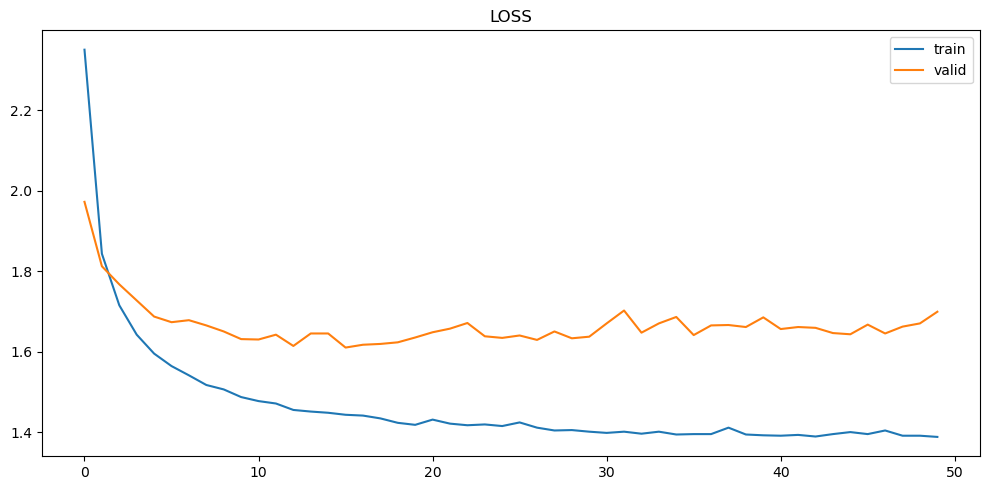

In [79]:
plt.figure(figsize = (10,5))
k=0
plt.title("LOSS")
plt.plot(epo_list, training_list[0], label = 'train')
plt.plot(epo_list, validing_list[0], label = 'valid')
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
## 학습 중 모델 저장 관련 변수
dir = './model/'
filename = dir + f"sign_{epoch_num}.pth"
print(filename)

./model/sign_50.pth


In [81]:
torch.save(model.state_dict(), filename)
print('모델 저장 완료')

모델 저장 완료


In [82]:
sign_name = pd.read_csv('./traffic_sign/labels.csv')

In [83]:
sign_name.head()

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [84]:
answer = 4

result = sign_name.iloc[answer][1]
print(result)

Speed limit (70km/h)
